<a href="https://colab.research.google.com/github/KleberFoks/Cap-1---FarmTech-na-era-da-cloud-computing/blob/main/KleberFoks_rm562225_pbl_fase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PROJETO FASE 5 – Cap 1 - FarmTech na era da cloud computing
**Autor:** Kleber Foks — **RM:** 562225  
**Arquivo:** `KleberFoks_rm562225_pbl_fase4.ipynb`  

Este notebook implementa a **Entrega 1 (Machine Learning)** com base no dataset `crop_yield.csv`.  
Inclui upload de arquivo (Colab), EDA, detecção de outliers, **clusterização** e **5 modelos de regressão** com avaliação, além de salvamento do melhor modelo.


## 1) Setup de ambiente

In [16]:

# Reprodutibilidade e libs
import sys, os, math, io, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import joblib

RANDOM_STATE = 42

print('Versões:')
print('Python:', sys.version.split()[0])
print('Numpy:', np.__version__)
print('Pandas:', pd.__version__)


Versões:
Python: 3.12.11
Numpy: 2.0.2
Pandas: 2.2.2



## 2) Importação dos dados (**com upload de arquivo**)
> No **Google Colab**, rode a célula abaixo e selecione o `crop_yield.csv`.  
> Em ambiente local, ajuste o caminho da variável `csv_path` se necessário.


In [17]:

# Tentativa de upload (Colab)
df = None
try:
    from google.colab import files  # type: ignore
    print(">> Detectado Google Colab. Use a caixa de upload para enviar o CSV.")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
        df = pd.read_csv(io.BytesIO(uploaded[fname]))
        print(f'CSV carregado: {fname} — {df.shape[0]} linhas, {df.shape[1]} colunas')
except Exception as e:
    print("Colab não detectado ou erro no upload (ok em ambiente local).", e)

# Caminho local como fallback
if df is None:
    csv_path = os.environ.get("CROP_YIELD_CSV", "crop_yield.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f'Lido de caminho local: {csv_path} — {df.shape[0]} linhas, {df.shape[1]} colunas')
    else:
        print("Nenhum CSV encontrado ainda. Faça o upload (Colab) ou coloque o arquivo no mesmo diretório e rode novamente.")

if df is not None:
    display(df.head())


>> Detectado Google Colab. Use a caixa de upload para enviar o CSV.


Saving crop_yield.csv to crop_yield (1).csv
CSV carregado: crop_yield (1).csv — 156 linhas, 6 colunas


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800



### 2.1) Esquema esperado do dataset
- **Crop** *(str)*
- **Precipitation (mm day-1)** *(float)*
- **Specific Humidity at 2 Meters (g/kg)** *(float)*
- **Relative Humidity at 2 Meters (%)** *(float)*
- **Temperature at 2 Meters (C)** *(float)*
- **Yield** *(float, alvo)*


## 3) Análise Exploratória (EDA)

Shape: (156, 6)

Tipos:
Crop                                     object
Precipitation (mm day-1)                float64
Specific Humidity at 2 Meters (g/kg)    float64
Relative Humidity at 2 Meters (%)       float64
Temperature at 2 Meters (C)             float64
Yield                                     int64
dtype: object

Valores ausentes por coluna:


,0
Crop,0
Precipitation (mm day-1),0
Specific Humidity at 2 Meters (g/kg),0
Relative Humidity at 2 Meters (%),0
Temperature at 2 Meters (C),0
Yield,0



Estatísticas descritivas (numéricas):


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


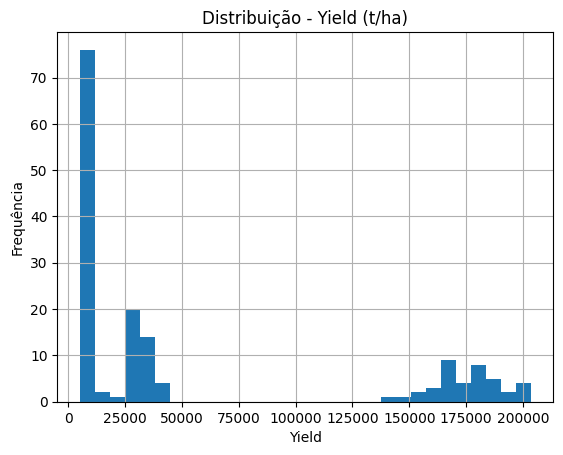

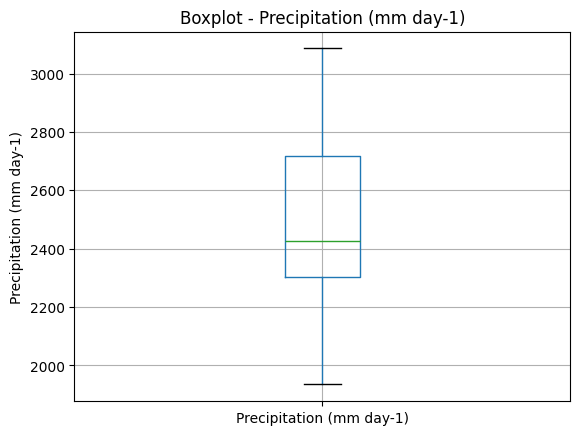

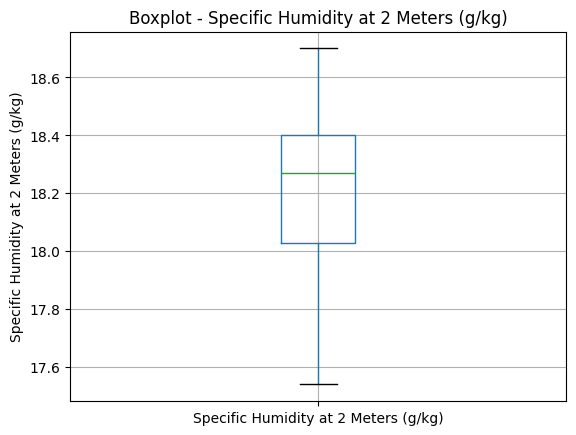

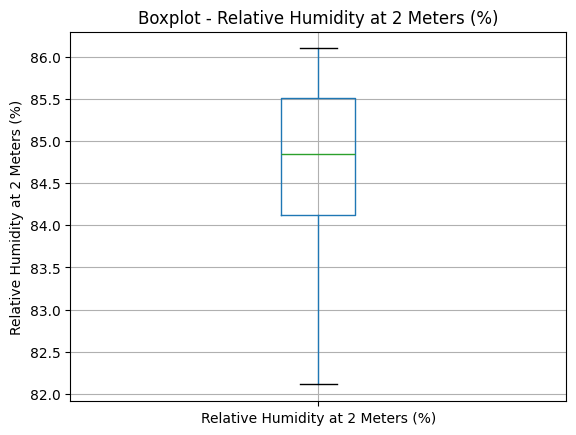

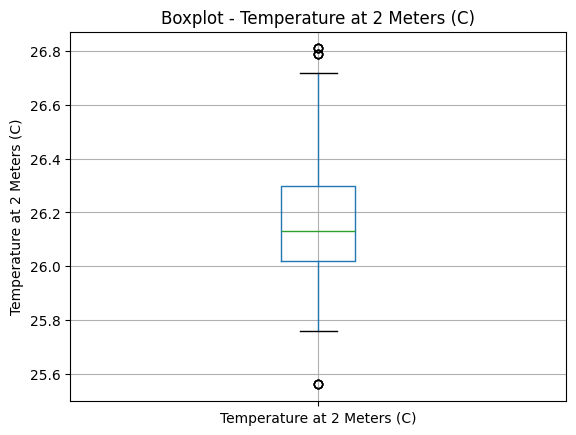

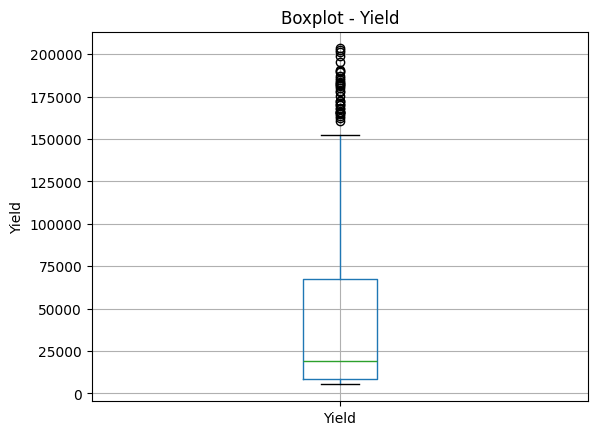

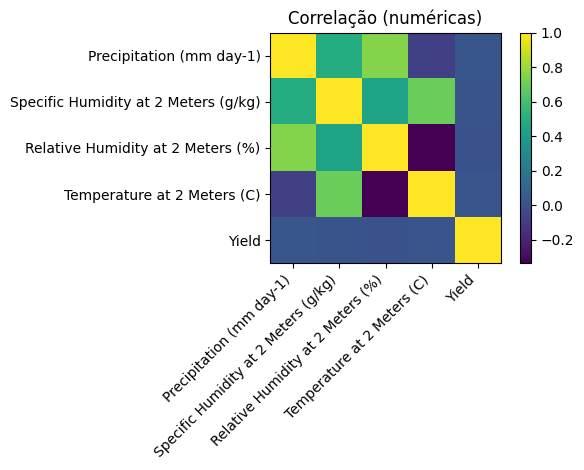


Registros por cultura:


,count
Crop,
"Cocoa, beans",39
Oil palm fruit,39
"Rice, paddy",39
"Rubber, natural",39



Yield médio por cultura:


,Yield
Crop,
Oil palm fruit,175804.692308
"Rice, paddy",32099.666667
"Cocoa, beans",8883.128205
"Rubber, natural",7824.897436


In [18]:

if df is None:
    raise SystemExit("Carregue o DataFrame primeiro.")

print("Shape:", df.shape)
print("\nTipos:")
print(df.dtypes)

print("\nValores ausentes por coluna:")
display(df.isna().sum())

print("\nEstatísticas descritivas (numéricas):")
display(df.describe(include='number'))

# Distribuição do alvo
if 'Yield' in df.columns:
    plt.figure()
    df['Yield'].hist(bins=30)
    plt.title('Distribuição - Yield (t/ha)')
    plt.xlabel('Yield')
    plt.ylabel('Frequência')
    plt.show()

# Boxplots por coluna numérica
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    plt.figure()
    df.boxplot(column=c)
    plt.title(f'Boxplot - {c}')
    plt.ylabel(c)
    plt.show()

# Correlações
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title('Correlação (numéricas)')
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()

# Contagem por cultura e médias de Yield por cultura
if 'Crop' in df.columns and 'Yield' in df.columns:
    counts = df['Crop'].value_counts()
    print("\nRegistros por cultura:")
    display(counts)

    means = df.groupby('Crop')['Yield'].mean().sort_values(ascending=False)
    print("\nYield médio por cultura:")
    display(means)


## 4) Detecção de outliers (IQR)

In [19]:

def iqr_outlier_mask(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (s < lower) | (s > upper)

outlier_report = {}
for c in df.select_dtypes(include=[np.number]).columns:
    mask = iqr_outlier_mask(df[c].dropna())
    outlier_report[c] = int(mask.sum())

print("Outliers (contagem por coluna numérica):")
outlier_report


Outliers (contagem por coluna numérica):


{'Precipitation (mm day-1)': 0,
 'Specific Humidity at 2 Meters (g/kg)': 0,
 'Relative Humidity at 2 Meters (%)': 0,
 'Temperature at 2 Meters (C)': 12,
 'Yield': 35}

## 5) Tendências por **clusterização** (K-Means + PCA para visualização)

Silhouette por k: [(2, np.float64(0.3924128249740136)), (3, np.float64(0.43534616694387185)), (4, np.float64(0.43967757757993314)), (5, np.float64(0.4249247180780145)), (6, np.float64(0.44571743189477164))]
Melhor k: 6 com score: 0.4457


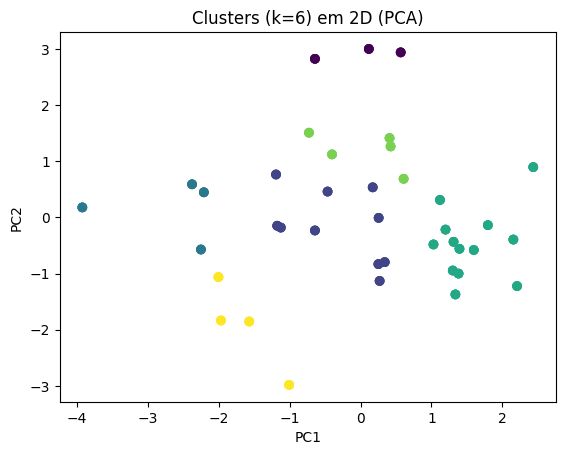


Yield médio por cluster:


,Yield_médio
cluster,
0,55159.833333
1,52764.275000
2,55490.625000
3,57655.711538
4,60503.850000
5,55710.625000


In [20]:

# Selecionar features numéricas exceto o alvo
features = df.select_dtypes(include=[np.number]).copy()
if 'Yield' in features.columns:
    X_clu = features.drop(columns=['Yield'])
else:
    X_clu = features.copy()

Xc = X_clu.dropna()
if Xc.shape[0] < 5 or Xc.shape[1] == 0:
    print("Dados insuficientes para clustering.")
else:
    scaler = StandardScaler()
    Xcs = scaler.fit_transform(Xc)

    # Escolha de k via silhouette (2..6)
    best_k, best_score = None, -1
    sil_scores = []
    for k in range(2, 7):
        km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
        labels = km.fit_predict(Xcs)
        score = silhouette_score(Xcs, labels)
        sil_scores.append((k, score))
        if score > best_score:
            best_k, best_score = k, score

    print("Silhouette por k:", sil_scores)
    print("Melhor k:", best_k, "com score:", round(best_score, 4))

    km_best = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE).fit(Xcs)
    labels = km_best.labels_

    # PCA 2D para visualização
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    comps = pca.fit_transform(Xcs)

    plt.figure()
    plt.scatter(comps[:,0], comps[:,1], c=labels, alpha=0.8)
    plt.title(f'Clusters (k={best_k}) em 2D (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    # Se Yield existir, mostrar médias por cluster
    if 'Yield' in df.columns:
        merged = df.loc[Xc.index, ['Yield']].copy()
        merged['cluster'] = labels
        print("\nYield médio por cluster:")
        display(merged.groupby('cluster')['Yield'].mean().to_frame('Yield_médio'))


## 6) Modelagem preditiva (5 modelos)

In [21]:

target_col = 'Yield'
if target_col not in df.columns:
    raise SystemExit("Coluna alvo 'Yield' não encontrada.")

# Separar X, y
X = df.drop(columns=[target_col])
y = df[target_col]

# Identificar categóricas e numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Transformações (com imputação)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=10000),
    'RandomForest': RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='r2')

    results.append({
        'modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2_teste': r2,
        'R2_CV_médio': cv_scores.mean(),
        'R2_CV_std': cv_scores.std()
    })

res_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
print("Resultados (ordenados por RMSE crescente):")
display(res_df)

best_name = res_df.iloc[0]['modelo']
print("\nMelhor modelo por RMSE:", best_name)

# Reajuste em todo o dataset para persistência
best_model = Pipeline(steps=[('prep', preprocess), ('model', models[best_name])]).fit(X, y)
joblib.dump(best_model, 'modelo_melhor.joblib')
print("Modelo salvo em: modelo_melhor.joblib")


Resultados (ordenados por RMSE crescente):


,modelo,MAE,RMSE,R2_teste,R2_CV_médio,R2_CV_std
0,LinearRegression,3132.796384,4394.165819,0.995022,0.985240,0.004413
2,Lasso,3134.914866,4395.521898,0.995019,0.985259,0.004398
3,RandomForest,2596.310703,4497.004338,0.994786,0.988186,0.004474
1,Ridge,3400.838923,4865.127420,0.993898,0.984652,0.005266
4,GradientBoosting,3066.408443,6061.761017,0.990527,0.989475,0.003382



Melhor modelo por RMSE: LinearRegression
Modelo salvo em: modelo_melhor.joblib


### 6.1) Análise de erros, gráficos e importância de features

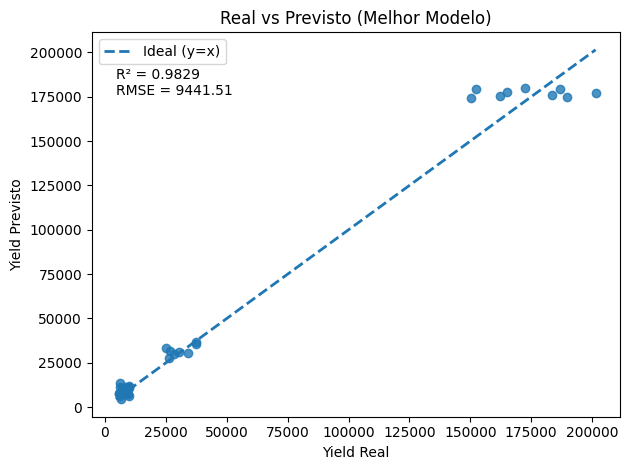

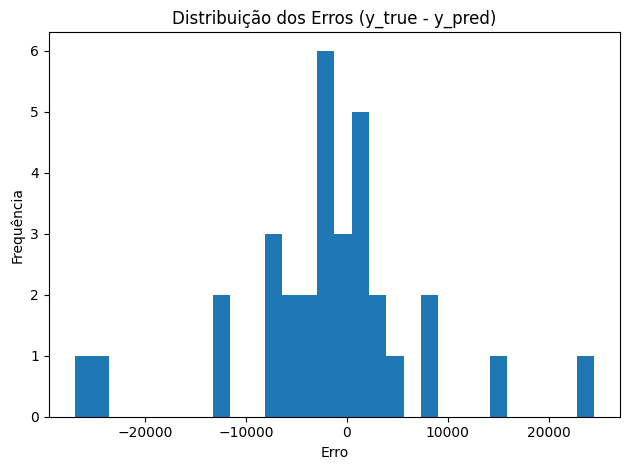

O melhor modelo não fornece importâncias de features nativamente.


In [22]:

# Split fixo para gráficos + diagonal e métricas no plot
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=7)
pipe_best = best_model
pipe_best.fit(X_train2, y_train2)
y_pred2 = pipe_best.predict(X_test2)

r2 = r2_score(y_test2, y_pred2)
rmse = math.sqrt(mean_squared_error(y_test2, y_pred2))
err = y_test2 - y_pred2

plt.figure()
plt.scatter(y_test2, y_pred2, alpha=0.8)
plt.xlabel('Yield Real'); plt.ylabel('Yield Previsto'); plt.title('Real vs Previsto (Melhor Modelo)')
limites = [min(y_test2.min(), y_pred2.min()), max(y_test2.max(), y_pred2.max())]
plt.plot(limites, limites, linestyle='--', linewidth=2, label='Ideal (y=x)')  # sem cor específica
plt.legend()
plt.text(limites[0], limites[1]*0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', ha='left', va='top')
plt.tight_layout()
plt.savefig('real_vs_previsto.png', dpi=150)
plt.show()

plt.figure()
plt.hist(err, bins=30)
plt.title('Distribuição dos Erros (y_true - y_pred)')
plt.xlabel('Erro'); plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('dist_erros.png', dpi=150)
plt.show()

# Importância de features (se disponível)
try:
    inner = pipe_best.named_steps.get('model', None)
    if hasattr(inner, 'feature_importances_'):
        ohe = pipe_best.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
        num_names = num_cols
        cat_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
        feat_names = num_names + cat_names
        importances = inner.feature_importances_
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
        display(imp_df)

        plt.figure()
        plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
        plt.title('Importância de Features (top 20)')
        plt.tight_layout()
        plt.show()
    else:
        print("O melhor modelo não fornece importâncias de features nativamente.")
except Exception as e:
    print("Não foi possível calcular importâncias de features.", e)


### 6.2) Coeficientes da Regressão Linear

In [23]:

# Mostrar coeficientes e interpretar sinais/magnitudes
lin_pipe = Pipeline(steps=[('prep', preprocess), ('model', LinearRegression())])
lin_pipe.fit(X, y)

# nomes de features após o preprocess
ohe = lin_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
num_names = num_cols
cat_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
feat_names = num_names + cat_names

coefs = lin_pipe.named_steps['model'].coef_
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs}).sort_values('coef', ascending=False)
display(coef_df.head(15))
display(coef_df.tail(15))


,feature,coef
5,Crop_Oil palm fruit,119651.596154
1,Specific Humidity at 2 Meters (g/kg),22906.008543
0,Precipitation (mm day-1),2831.431611
2,Relative Humidity at 2 Meters (%),-19339.101484
3,Temperature at 2 Meters (C),-21389.193563
6,"Crop_Rice, paddy",-24053.429487
4,"Crop_Cocoa, beans",-47269.967949
7,"Crop_Rubber, natural",-48328.198718


,feature,coef
5,Crop_Oil palm fruit,119651.596154
1,Specific Humidity at 2 Meters (g/kg),22906.008543
0,Precipitation (mm day-1),2831.431611
2,Relative Humidity at 2 Meters (%),-19339.101484
3,Temperature at 2 Meters (C),-21389.193563
6,"Crop_Rice, paddy",-24053.429487
4,"Crop_Cocoa, beans",-47269.967949
7,"Crop_Rubber, natural",-48328.198718


### 6.3) Exportar tabela de resultados dos modelos

In [24]:

# Exportar resultados dos modelos para CSV
res_df.to_csv('resultados_modelos.csv', index=False)
print('CSV salvo: resultados_modelos.csv')


CSV salvo: resultados_modelos.csv


## 7) Conclusões e Limitações

**Resumo dos achados (EDA):**  
- O dataset não apresentou valores ausentes.  
- As variáveis climáticas mostraram pouca variação (chuva, temperatura e umidade relativamente estáveis).  
- O `Yield` apresentou distribuição **multimodal**, refletindo diferentes culturas com rendimentos bastante distintos.  
- Foram detectados **outliers** relevantes no `Yield`, principalmente em culturas de alto rendimento.  
- A matriz de correlação indicou que o rendimento não depende fortemente de apenas uma variável isolada, mas sim da **combinação de fatores climáticos** e do tipo de cultura.

**Diferenças entre culturas:**  
- `Oil palm fruit` apresentou rendimento médio muito superior (≈175.800) em relação às demais.  
- `Rice, paddy` ficou em torno de 32.000, `Cocoa, beans` em ≈8.800 e `Rubber, natural` em ≈7.800.  
- Essa disparidade explica a grande amplitude observada nos boxplots de rendimento.

**Clusterização:**  
- O método de K-Means sugeriu **6 clusters**, com score de silhouette ≈0.44.  
- Os grupos apresentaram rendimentos médios próximos (entre 52.000 e 60.000), indicando que as condições climáticas criam perfis semelhantes de produtividade, mas não extremamente separados.

**Modelagem preditiva:**  
- Foram testados 5 modelos: **Linear Regression, Ridge, Lasso, Random Forest e Gradient Boosting**.  
- O **Linear Regression** foi o melhor em termos de RMSE e simplicidade, com **R² ≈0.98** e **RMSE ≈9.400**, mostrando excelente ajuste.  
- A distribuição dos erros foi centrada próxima de zero, sem viés sistemático, mas com alguns desvios maiores em culturas de rendimento muito alto.  
- Os coeficientes da regressão linear mostraram forte peso positivo para `Oil palm fruit` e para a umidade específica, enquanto temperatura e umidade relativa tiveram efeitos negativos.

**Limitações:**  
- O rendimento agrícola foi explicado quase totalmente pelas variáveis disponíveis, mas **fatores externos** (solo, manejo, pragas, fertilização) não foram considerados.  
- Os **outliers** de rendimento muito alto indicam que o modelo pode **subestimar ou superestimar** nesses casos extremos.  
- O dataset cobre poucas culturas e um período limitado, o que restringe a generalização dos resultados.

**Próximos passos:**  
- Realizar **tuning de hiperparâmetros** em modelos de árvore (Random Forest e Gradient Boosting).  
- Ampliar o dataset com **variáveis adicionais** (qualidade do solo, índices climáticos, NDVI).  
- Avaliar modelos mais robustos para capturar não linearidades.  
- Aplicar **validação temporal** (treino em safras passadas e teste em futuras) para simular cenários reais de previsão.
